In [77]:
import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import torch
import scipy.special as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import scipy.stats
import seaborn as sns

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt 
matplotlib.rcdefaults()

matplotlib_rc = { 
    # 'text': {'usetex': True}, 
    'font': {'family': 'serif'} } # Apply changes for k, v in matplotlib_rc.items(): rc(k, **v)
for k, v in matplotlib_rc.items():
          rc(k, **v)

In [18]:
def corrupt_dataset(adata):
    """
    Corrupts entries in an AnnData object's matrix with a probability of 0.1%.
    
    Parameters
    ----------
    adata : AnnData
        The AnnData object whose data matrix (adata.X) will be corrupted.
        This works for both dense and sparse matrices.

    Returns
    -------
    None
        The function modifies the adata object in place.
    """
    # Only keep highly variable genes
    adata = adata[:, adata.var.highly_variable]

    # Shape of the dropout Bernoulli matrix 
    dim = adata.X.shape
    
    # Generate a mask of the same shape as the data matrix, with 0.1% probability of corruption
    np.random.seed(42)
    corruption_mask = 1-np.random.binomial(n=1, p=0.1, size=dim).astype(bool)
    print("Dropped out", (corruption_mask==0).sum())
    print("Kept", (corruption_mask==1).sum())

    # Corrupt matrix by multiplying it by the mask 
    corrupted_mat = adata.layers["X_counts"].A * corruption_mask

    adata.layers["X_masked"] = corrupted_mat

    adata.uns["do_ix"] = np.where(corruption_mask.ravel()==0)[0]
    return adata

**Tabula Muris**

In [19]:
tabula_muris = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/tabula_muris/tabula_muris.h5ad")
sc.pp.subsample(tabula_muris, n_obs=50000)
tabula_muris = corrupt_dataset(tabula_muris)
tabula_muris.layers["X_masked"] = csr_matrix(tabula_muris.layers["X_masked"])
tabula_muris.write_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/dropout/tabula_muris.h5ad")

Dropped out 9997476
Kept 90002524


/tmp/ipykernel_2454845/42061576.py:31: ImplicitModificationWarning: Setting element `.layers['X_masked']` of view, initializing view as actual.
  adata.layers["X_masked"] = corrupted_mat


## Train scVI on the masked data 

In [10]:
# Set up the anndata
scvi.model.SCVI.setup_anndata(tabula_muris, 
                              layer="X_masked",
                              categorical_covariate_keys=["tissue"])

# SCVI model
model = scvi.model.SCVI(tabula_muris, n_layers=3, n_latent=100, gene_likelihood="nb")

# Check for CUDA availability and specify device
use_cuda = torch.cuda.is_available()
device = "gpu" if use_cuda else "cpu"
print(f"Using device: {device}")

# Train model 
model.train(max_epochs=100, accelerator=device)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using device: gpu


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [04:33<00:00,  2.57s/it, v_num=1, train_loss_step=352, train_loss_epoch=339]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [04:33<00:00,  2.73s/it, v_num=1, train_loss_step=352, train_loss_epoch=339]


In [64]:
imputed_counts = model.get_normalized_expression(tabula_muris,
                            indices=None,
                            transform_batch=None,
                            gene_list = None,
                            library_size = 1,
                            n_samples = 1,
                            n_samples_overall = None,
                            weights = None,
                            batch_size = None,
                            return_mean = True,
                            return_numpy = None,
                            )
imputed_counts = imputed_counts.values*tabula_muris.layers["X_counts"].A.sum(1)[:,None]

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


All expression is normalized to sum to 1

In [65]:
np.mean(np.abs(imputed_counts.ravel()[tabula_muris.uns['do_ix']] - tabula_muris.layers["X_counts"].A.ravel()[tabula_muris.uns['do_ix']]))

0.46945524

## Train CFGen on the masked data 

In [13]:
import os
from pathlib import Path
import uuid
import torch
from torch.utils.data import random_split
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from celldreamer.paths import TRAINING_FOLDER
from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import MLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.fm.ode import torch_wrapper
from torchdyn.core import NeuralODE

### Encoder training

Initialize dataloader 

In [20]:
data_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/dropout/tabula_muris.h5ad"

All masked values are indeed 0

In [21]:
print(tabula_muris.layers["X_counts"].A.ravel()[tabula_muris.uns["do_ix"].ravel()])
print(tabula_muris.layers["X_masked"].A.ravel()[tabula_muris.uns["do_ix"].ravel()])

[0. 4. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [23]:
# Initialize dataloaders for the different tasks 
dataset = RNAseqLoader(data_path=data_path,
                        layer_key="X_masked",               # Corresponding to config 'layer_key'
                        covariate_keys=["tissue"],        # Corresponding to config 'covariate_keys'
                        subsample_frac=1,                   # Corresponding to config 'subsample_frac'
                        encoder_type="learnt_autoencoder",  # Corresponding to config 'encoder_type'
                        multimodal=False,                   # Corresponding to config 'multimodal'
                        is_binarized=False                  # Corresponding to config 'is_binarized'
                    )

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [24]:
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=256,
                                        shuffle=True,
                                        num_workers=4, 
                                        drop_last=True)
gene_dim = dataset.X.shape[1] 

Initialize encoder

In [26]:
encoder_model = EncoderModel(
    in_dim=gene_dim,
    n_cat=None,
    conditioning_covariate="tissue",   # From the first config file
    encoder_type="learnt_autoencoder",   # From the first config file
    x0_from_x_kwargs = {
        "dims":[512, 256, 100],                # From x0_from_x_kwargs.dims
        "batch_norm":True,                     # From x0_from_x_kwargs.batch_norm
        "dropout":False,                       # From x0_from_x_kwargs.dropout
        "dropout_p":0.0},                       # From x0_from_x_kwargs.dropout_p
    learning_rate=0.001,                 # From yaml learning_rate
    weight_decay=0.00001,                # From yaml weight_decay
    covariate_specific_theta=False,      # From yaml covariate_specific_theta
    multimodal=False,                    # From yaml multimodal
    is_binarized=False                   # From yaml is_binarized
)

In [27]:
trainer_generative = Trainer(max_epochs=100)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` 

In [28]:
trainer_generative.fit(
            encoder_model,
            train_dataloaders=dataloader,
            val_dataloaders=dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | x0_from_x    | MLP  | 1.2 M  | train
1 | x_from_x0    | MLP  | 1.2 M  | train
  | other params | n/a  | 2.0 K  | n/a  
----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.480     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### Flow training

Initialize the flow

In [29]:
# Latent dimension
in_dim = 100  
# No modality list 
modality_list = None 

Initialize the feature embeddings

In [30]:
feature_embeddings = {}  
num_classes = {}
        
for cov, cov_names in dataset.id2cov.items():
    feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                            False, 
                                                            "cuda", 
                                                            embedding_dimensions=100)

    num_classes[cov] = 100

Initialize the denoising model 

In [31]:
# Initialize the denoising model
denoising_model = MLPTimeStep(in_dim=in_dim,                            # Presumably pre-defined
                                hidden_dim=32,                            # From config hidden_dim
                                dropout_prob=0,                           # From config dropout_prob
                                n_blocks=3,                               # From config n_blocks
                                model_type="conditional_latent",          # From config model_type
                                size_factor_min=dataset.min_size_factor,  # From dataset properties
                                size_factor_max=dataset.max_size_factor,  # From dataset properties
                                embedding_dim=100,                         # From config embedding_dim
                                normalization="none",                     # From config normalization
                                conditional=True,                         # From config conditional
                                multimodal=False,                         # From config multimodal
                                is_binarized=False,                       # From config is_binarized
                                modality_list=None,                       # Assuming no specific modality list
                                embed_size_factor=False                   # From config embed_size_factor
                                ).to("cuda")

In [32]:
for param in encoder_model.parameters():
    param.requires_grad = False

In [33]:
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                        "sd": dataset.log_size_factor_sd}

generative_model = FM(
    encoder_model=encoder_model,
    denoising_model=denoising_model,
    feature_embeddings=feature_embeddings,
    plotting_folder="/home/icb/alessandro.palma/environment/cfgen/notebooks/experiments/imputation/plots/try1",
    in_dim=in_dim,
    size_factor_statistics=size_factor_statistics,
    encoder_type="learnt_autoencoder",
    conditioning_covariate="tissue",
    model_type=denoising_model.model_type,
    multimodal=dataset.multimodal,
    is_binarized=False,
    modality_list=None,
    learning_rate=0.0001,
    weight_decay=0.000001,
    antithetic_time_sampling=True,
    sigma=0.01,
    use_ot=False
)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


In [34]:
trainer_generative = Trainer(max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [35]:
trainer_generative.fit(generative_model,
                        train_dataloaders=dataloader,
                        val_dataloaders=dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type         | Params | Mode 
---------------------------------------------------------
0 | encoder_model   | EncoderModel | 2.4 M  | train
1 | denoising_model | MLPTimeStep  | 42.8 K | train
2 | criterion       | MSELoss      | 0      | train
---------------------------------------------------------
42.8 K    Trainable params
2.4 M     Non-trainable params
2.4 M     Total params
9.651     Total estimated model params size (MB)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'encoder_model' parameter because it is not possible to safely dump to YAML.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:363: Skipping 'denoising_model' parameter because it is not possible to safely dump to YAML.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [36]:
generative_model = generative_model.cuda()

# Implementation of augmentation appraches 

In [37]:
dataset = RNAseqLoader(data_path=data_path,
                        layer_key="X_masked",               # Corresponding to config 'layer_key'
                        covariate_keys=["tissue"],        # Corresponding to config 'covariate_keys'
                        subsample_frac=1,                   # Corresponding to config 'subsample_frac'
                        encoder_type="learnt_autoencoder",  # Corresponding to config 'encoder_type'
                        multimodal=False,                   # Corresponding to config 'multimodal'
                        is_binarized=False                  # Corresponding to config 'is_binarized'
                    )

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


#### Invert and sample

In [38]:
dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=False,
                                            num_workers=4, 
                                            drop_last=False)
gene_dim = dataset.X.shape[1] 

In [41]:
def invert_and_sample(dataloader, encoder_model, generative_model, sample_std=0.1):
    # Sampled results 
    Z_imputed = [] 
    X_imputed = []
    
    # Times to apply correction
    t = torch.linspace(0, 1, 100, device=generative_model.device)
    reverse_t = torch.linspace(1, 0, 100, device=generative_model.device)

    for i, batch in tqdm(enumerate(dataloader)):
        with torch.no_grad():
            # Encode latent space 
            z = encoder_model.encode(batch)
    
            # Get size factor
            size_factor = torch.tensor(tabula_muris.layers["X_counts"][(i*256):((i+1)*256)].sum(1)).squeeze()
            log_size_factor = torch.log(torch.tensor(tabula_muris.layers["X_counts"][(i*256):((i+1)*256)].sum(1))).squeeze()
            
    
            # Get condition embeddings
            y = generative_model.feature_embeddings["tissue"](batch["y"]["tissue"].cuda())
    
            # Go back to noise
            denoising_model_ode = torch_wrapper(generative_model.denoising_model, 
                                                log_size_factor, 
                                                y)    
            
            node = NeuralODE(denoising_model_ode,
                                    solver="dopri5", 
                                    sensitivity="adjoint", 
                                    atol=1e-5, 
                                    rtol=1e-5)        
    
            z0 = node.trajectory(z, t_span=reverse_t)[-1]

            # Now sample around noise
            noise = torch.randn_like(z0) * sample_std  # Gaussian noise
            z0 = z0 + noise
    
            z1 = node.trajectory(z0, t_span=t)[-1]
            Z_imputed.append(z1.cpu().numpy())
    
            # Now decode
            mu_hat = generative_model._decode(z1, size_factor.cuda().unsqueeze(1))
            X_imputed.append(mu_hat.cpu().numpy())

    Z_imputed = np.concatenate(Z_imputed, axis=0)
    X_imputed = np.concatenate(X_imputed, axis=0)
    return Z_imputed, X_imputed

In [42]:
Z_imputed, X_imputed = invert_and_sample(dataloader, encoder_model, generative_model, sample_std=0.0001)

196it [04:17,  1.31s/it]


In [43]:
print(Z_imputed.shape)
print(X_imputed.shape)

(50000, 100)
(50000, 2000)


In [44]:
np.mean(np.abs(X_imputed.ravel()[tabula_muris.uns['do_ix']] - tabula_muris.layers["X_counts"].A.ravel()[tabula_muris.uns['do_ix']]))

0.72458684

In [45]:
scipy.stats.spearmanr(X_imputed.ravel()[tabula_muris.uns['do_ix']], tabula_muris.layers["X_counts"].A.ravel()[tabula_muris.uns['do_ix']])

SignificanceResult(statistic=0.35948315809572545, pvalue=0.0)

In [46]:
scipy.stats.spearmanr(imputed_counts.ravel()[tabula_muris.uns['do_ix']], tabula_muris.layers["X_counts"].A.ravel()[tabula_muris.uns['do_ix']])

SignificanceResult(statistic=0.3655833497266887, pvalue=0.0)

Text(0, 0.5, 'Real')

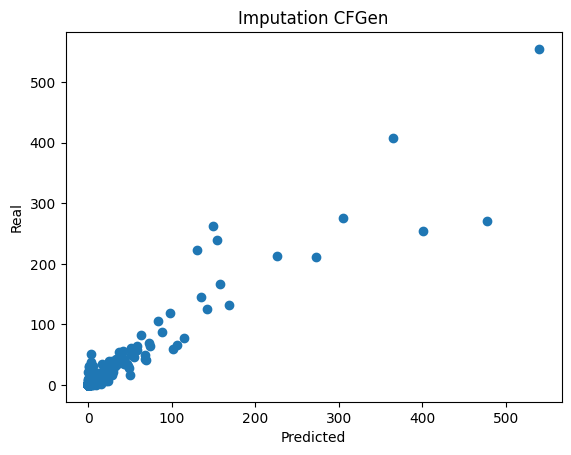

In [56]:
plt.scatter(X_imputed.ravel()[:20000], tabula_muris.layers["X_counts"].A.ravel()[:20000])
plt.title("Imputation CFGen")
plt.xlabel("Predicted")
plt.ylabel("Real")

Text(0, 0.5, 'Real')

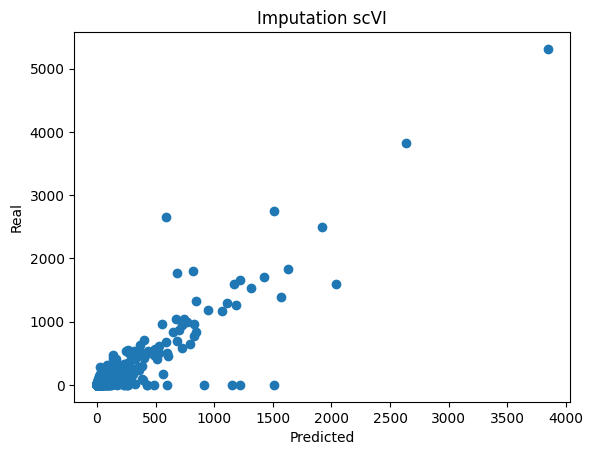

In [66]:
plt.scatter(imputed_counts.ravel()[:200000], tabula_muris.layers["X_counts"].A.ravel()[:200000])
plt.title("Imputation scVI")
plt.xlabel("Predicted")
plt.ylabel("Real")

## Correlation non zero genes

In [67]:
non_zero_idx = np.where(tabula_muris.layers["X_masked"].A.ravel()!=0)

In [68]:
scipy.stats.spearmanr(X_imputed.ravel()[non_zero_idx], tabula_muris.layers["X_counts"].A.ravel()[non_zero_idx])

SignificanceResult(statistic=0.8661507454685711, pvalue=0.0)

In [69]:
scipy.stats.spearmanr(imputed_counts.ravel()[non_zero_idx], tabula_muris.layers["X_counts"].A.ravel()[non_zero_idx])

SignificanceResult(statistic=0.7904394551233713, pvalue=0.0)

In [70]:
np.mean(np.abs(X_imputed.ravel()[non_zero_idx] - tabula_muris.layers["X_counts"].A.ravel()[[non_zero_idx]]))

4.81281

In [71]:
np.mean(np.abs(imputed_counts.ravel()[non_zero_idx] - tabula_muris.layers["X_counts"].A.ravel()[[non_zero_idx]]))

6.0794535

Check if generated are decent

In [62]:
adata_joint = sc.AnnData(X=np.concatenate([tabula_muris.layers["X_counts"].A,
                             X_imputed]),
                         obs={"dataset_type":["true" for _ in range(tabula_muris.layers["X_counts"].A.shape[0])]+["gen" for _ in range(len(X_imputed))]})

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


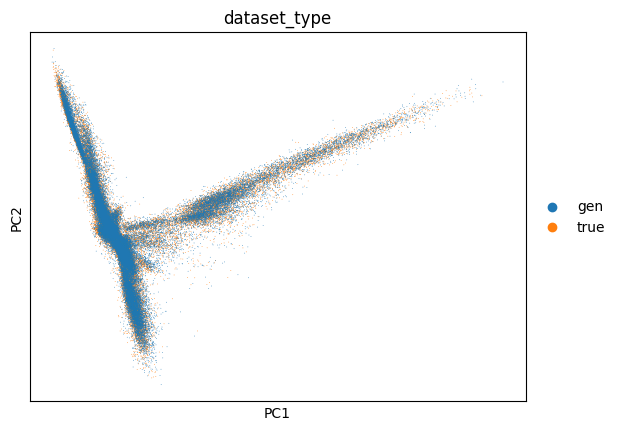

In [63]:
sc.pp.log1p(adata_joint)
sc.tl.pca(adata_joint)
sc.pl.pca(adata_joint,color="dataset_type")

#### Interpolate and sample

In [61]:
# def interpolate_and_sample(dataloader, encoder_model, generative_model, tmax):
#     # Sampled results 
#     Z_imputed = [] 
#     X_imputed = []
    
#     # Times to apply correction
#     t = torch.linspace(tmax, 1.0, 100, device=generative_model.device)

#     for i, batch in tqdm(enumerate(dataloader)):
#         with torch.no_grad():
#             # Encode latent space 
#             z = encoder_model.encode(batch)
#             eps = torch.randn_like(z)
    
#             # Get size factor
#             log_size_factor = torch.log(torch.tensor(tabula_muris.layers["X_counts"][(i*256):((i+1)*256)].sum(1))).squeeze()
    
#             # Get condition embeddings
#             y = generative_model.feature_embeddings["clusters"](batch["y"]["clusters"].cuda())

#             # Interpolate 
#             zt = z * tmax + eps * (1-tmax)
    
#             # Go back to noise
#             denoising_model_ode = torch_wrapper(generative_model.denoising_model, 
#                                                 log_size_factor, 
#                                                 y)    
            
#             node = NeuralODE(denoising_model_ode,
#                                     solver="dopri5", 
#                                     sensitivity="adjoint", 
#                                     atol=1e-5, 
#                                     rtol=1e-5)        
    
    
#             z1 = node.trajectory(zt, t_span=t)[-1]
#             Z_imputed.append(z1.cpu().numpy())
    
#             # Now decode
#             mu_hat = generative_model._decode(z1, torch.exp(log_size_factor).cuda().unsqueeze(1))
#             X_imputed.append(mu_hat.cpu().numpy())
            
#     Z_imputed = np.concatenate(Z_imputed, axis=0)
#     X_imputed = np.concatenate(X_imputed, axis=0)
#     return Z_imputed, X_imputed

In [60]:
# Z_imputed_interpolate, X_imputed_interpolate = interpolate_and_sample(dataloader,
#                                                                       encoder_model, 
#                                                                       generative_model, 
#                                                                       tmax=0.9)

In [59]:
# np.mean(np.abs(X_imputed_interpolate.ravel()[tabula_muris.uns['do_ix']] - tabula_muris.layers["X_counts"].A.ravel()[tabula_muris.uns['do_ix']]))

In [58]:
# plt.scatter(X_imputed_interpolate.ravel()[:100000], tabula_muris.layers["X_counts"].A.ravel()[:100000])
# plt.title("Imputation CFGen")
# plt.xlabel("Predicted")
# plt.ylabel("Real")

### Plot together

In [124]:
scvi_pred = imputed_counts.ravel()[non_zero_idx][:100000]
cfg_pred = X_imputed.ravel()[non_zero_idx][:100000]
real_counts = tabula_muris.layers["X_counts"].A.ravel()[non_zero_idx][:100000]

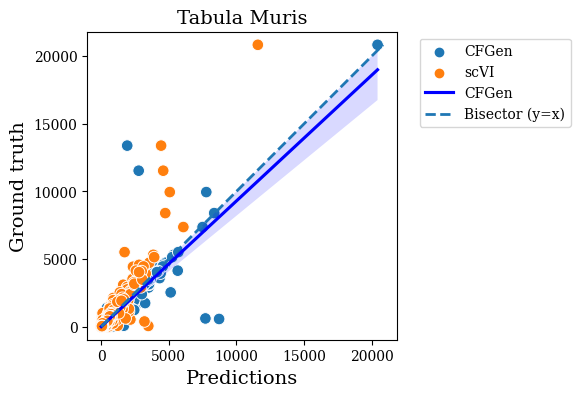

In [126]:
# # Prepare the data for seaborn
# data = pd.DataFrame({
#     "Ground truth": np.concatenate([real_counts, real_counts]),
#     "Predictions": np.concatenate([cfg_pred, scvi_pred]),
#     "Model": ["CFGen"] * len(real_counts) + ["scVI"] * len(real_counts)
# })

# # Initialize the plot
# plt.figure(figsize=(4, 4))

# # Scatter plot with regression lines
# sns.scatterplot(data=data, x="Predictions", y="Ground truth", hue="Model", s=70)
# sns.regplot(data=data[data["Model"] == "CFGen"], x="Predictions", y="Ground truth", scatter=False, color="blue", label="CFGen")
# sns.regplot(data=data[data["Model"] == "scVI"], x="Predictions", y="Ground truth", scatter=False, color="orange", label="scVI")

# # Add the y=x line (bisector)
# plt.plot([min(real_counts), max(real_counts)], [min(real_counts), max(real_counts)],  linestyle="--", linewidth=2, label="Bisector (y=x)")

# # Adjust plot aesthetics
# plt.title("Tabula Muris", fontsize=14)
# plt.ylabel("Ground truth", fontsize=14)
# plt.xlabel("Predictions", fontsize=14)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend outside
# plt.axis("equal")
# # plt.tight_layout()
# plt.savefig("plots/tabula_muris_comparison.png", bbox_inches='tight', format="png")  # Save the figure
# # Show the plot
# plt.show()

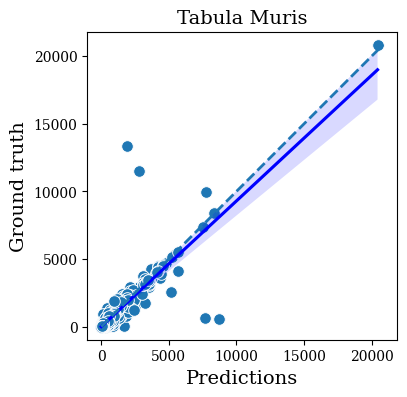

In [127]:
# Prepare the data for seaborn
data = pd.DataFrame({
    "Ground truth": real_counts,
    "Predictions": cfg_pred,
    "Model": ["CFGen"] * len(real_counts) 
})

# Initialize the plot
plt.figure(figsize=(4, 4))

# Scatter plot with regression lines
sns.scatterplot(data=data, x="Predictions", y="Ground truth", s=70)
sns.regplot(data=data[data["Model"] == "CFGen"], x="Predictions", y="Ground truth", scatter=False, color="blue", label="CFGen")

# Add the y=x line (bisector)
plt.plot([min(real_counts), max(real_counts)], [min(real_counts), max(real_counts)],  linestyle="--", linewidth=2, label="Bisector (y=x)")

# Adjust plot aesthetics
plt.title("Tabula Muris", fontsize=14)
plt.ylabel("Ground truth", fontsize=14)
plt.xlabel("Predictions", fontsize=14)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend outside
plt.axis("equal")
# plt.tight_layout()
plt.savefig("plots/tabula_muris_comparison.png", bbox_inches='tight', format="png")  # Save the figure
# Show the plot
plt.show()

Now make plots with multiple levels of noise 

196it [04:29,  1.37s/it]


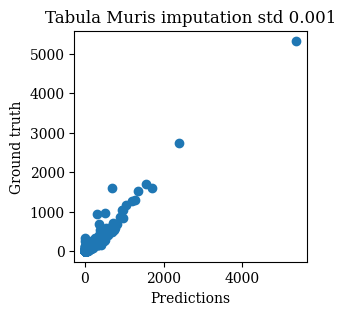

SignificanceResult(statistic=0.8661500308009904, pvalue=0.0)
4.8128815


196it [04:16,  1.31s/it]


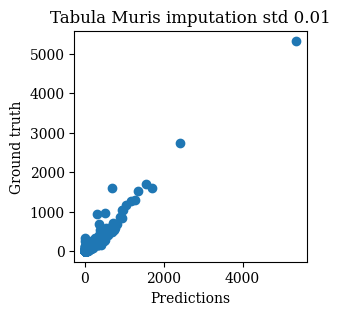

SignificanceResult(statistic=0.8661168294670942, pvalue=0.0)
4.8149467


196it [04:25,  1.35s/it]


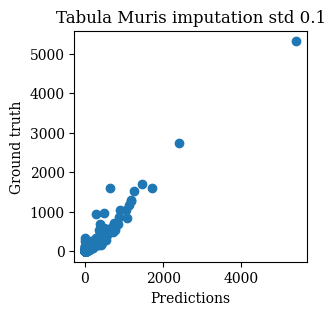

SignificanceResult(statistic=0.8627939422456946, pvalue=0.0)
4.9756727


196it [04:54,  1.50s/it]


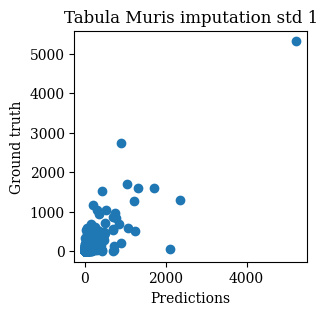

SignificanceResult(statistic=0.6538637901861658, pvalue=0.0)
11.706042


196it [05:00,  1.53s/it]


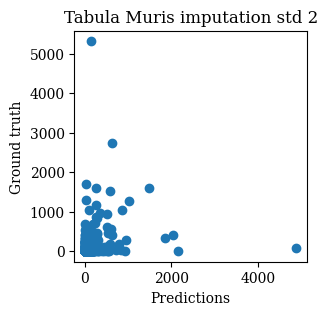

SignificanceResult(statistic=0.4435749624275439, pvalue=0.0)
16.243189


196it [06:49,  2.09s/it]


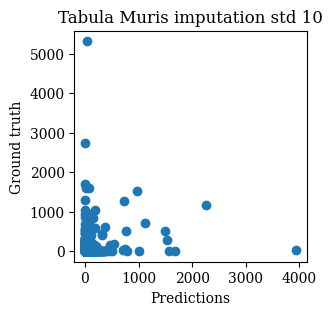

SignificanceResult(statistic=0.1558959142798207, pvalue=0.0)
18.20558


In [88]:
for std in [0.001, 0.01, 0.1, 1, 2, 10]:
    _, X_imputed_var = invert_and_sample(dataloader, encoder_model, generative_model, sample_std=std)
    plt.figure(figsize=(3, 3))
    plt.scatter(X_imputed_var.ravel()[:100000], tabula_muris.layers["X_counts"].A.ravel()[:100000])
    plt.title(f"Tabula Muris imputation std {std}")
    plt.xlabel("Predictions")
    plt.ylabel("Ground truth")
    plt.savefig(f"plots/var_plots/tabula_muris_comparison_{std}.png",bbox_inches='tight', format="png")  # Save the figure
    plt.show()
    print(scipy.stats.spearmanr(X_imputed_var.ravel()[non_zero_idx], tabula_muris.layers["X_counts"].A.ravel()[non_zero_idx]))
    print(np.mean(np.abs(X_imputed_var.ravel()[non_zero_idx] - tabula_muris.layers["X_counts"].A.ravel()[[non_zero_idx]])))